In [1]:
;pwd

/Users/Jorge/projects/Apophis/notebooks


In [2]:
]activate ..

In [3]:
using Revise

┌ Info: Recompiling stale cache file /Users/Jorge/.julia/compiled/v1.1/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1184


In [4]:
using Apophis

┌ Info: Precompiling Apophis [b41c07a2-2abb-11e9-070a-c3c1b239e7df]
└ @ Base loading.jl:1186


length(methods(RNp1BP_pN_A_J234E_J2S_ng!)) = 1
length(methods(TaylorIntegration.jetcoeffs!)) = 3
methods(RNp1BP_pN_A_J234E_J2S_ng!) = # 1 method for generic function "RNp1BP_pN_A_J234E_J2S_ng!":
[1] RNp1BP_pN_A_J234E_J2S_ng!(t, q, dq) in Apophis at /Users/Jorge/projects/Apophis/src/asteroid_dynamical_model.jl:2
t0 == 2.4547335e6 = true


In [5]:
methods(Apophis.delay_doppler)

# 2 methods for generic function "delay_doppler":
[1] delay_doppler(x, station_code, t_r_utc_julian, f_T) in Apophis at /Users/Jorge/projects/Apophis/src/delay_doppler.jl:7
[2] delay_doppler(x, station_code, t_r_utc_julian, f_T, niter::Int64) in Apophis at /Users/Jorge/projects/Apophis/src/delay_doppler.jl:7

In [6]:
methods(Apophis.delay_doppler_jpleph)

# 2 methods for generic function "delay_doppler_jpleph":
[1] delay_doppler_jpleph(station_code, t_r_utc_julian, f_T) in Apophis at /Users/Jorge/projects/Apophis/src/delay_doppler.jl:185
[2] delay_doppler_jpleph(station_code, t_r_utc_julian, f_T, niter::Int64) in Apophis at /Users/Jorge/projects/Apophis/src/delay_doppler.jl:185

In [7]:
Apophis.eph

CALCEPH.Ephem(Ptr{Nothing} @0x00007fa8d99e5800)

In [8]:
# using TaylorIntegration, LinearAlgebra # Apophis.jl @reexports TaylorIntegration and LinearAlgebra
using Plots, JLD, DelimitedFiles, Dates
using Statistics: mean, std
using AstroTime

#12: Solar System Barycenter
#11: Sun (heliocenter)
#2099942: Apophis
#3: Earth (geocenter)
#10: Moon
eph = Ephem(["jpleph/a99942.bsp", "jpleph/de430.bsp"])
prefetch(eph)
apophis_posvel = compute(eph,2454733.0,0.51, 2099942, 12, unitKM+unitDay,1)/au
sun_posvel = compute(eph,2454733.5,0.0, 11, 12, unitKM+unitDay,1)/au
earth_posvel = compute(eph,2454733.0,0.6, 3, 12, unitKM+unitDay,1)/au
moon_posvel = compute(eph,2454733.0,0.6, 10, 12, unitKM+unitDay,1)/au
@show apophis_posvel
@show sun_posvel
@show earth_posvel
@show moon_posvel;

In [9]:
# recover integration from .jld file
vars = ["tv_jpl_integ", "xv1", "tvS1", "xvS1", "gvS1"] #names of variables
filename = string("Apophis_jt.jld")
for i in eachindex(vars)
    ex = Symbol(vars[i])
    @eval $ex = load($filename, vars[$i])
end

sort(union(apophisdofs, ssdofs)) == collect(1:72)

xv1[2,apophisdofs]

xv1[2,sundofs]

xv1[20,ssdofs[end-6:end]]

In [10]:
jpl_radar = readdlm("../Apophis_JPL_data.dat", '\t')

46×9 Array{Any,2}:
 "99942 Apophis (2004 MN4)"  …  0.25   "Hz"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     4.0    "us"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     0.25   "Hz"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     4.5    "us"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     0.15   "Hz"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"  …  0.2    "Hz"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     0.1    "Hz"  2380  251  251  "C"
 "99942 Apophis (2004 MN4)"     0.25   "Hz"  8560  253  253  "C"
 "99942 Apophis (2004 MN4)"     0.1    "Hz"  8560  253  253  "C"
 "99942 Apophis (2004 MN4)"     0.25   "us"  8560  253  253  "C"
 "99942 Apophis (2004 MN4)"  …  0.25   "us"  8560  253  253  "C"
 "99942 Apophis (2004 MN4)"     0.1    "Hz"  8560  253  253  "C"
 "99942 Apophis (2004 MN4)"     3.0    "us"  8560  253  253  "C"
 ⋮                           ⋱                  ⋮               
 "99942 Apophis (2004 MN4)"     0.1    "Hz"  8560  253  253  "C"
 "9994

findall(x -> x == "Hz", jpl_radar[:,5])

findall(x -> x == "us", jpl_radar[:,5])

hola1 = jpl_radar[:,5] .== "Hz"
hola2 = jpl_radar[:,5] .== "us"
hola3 = hola1 .| hola2
hola4 = hola1 .& hola2
all(hola3), !any(hola4)

jpl_radar[:,2]

In [11]:
#construct vector of observation times
#####`union` removes repeated elements
#NOTE: resulting vector does not include t0
# tv_jpl = union( Dates.datetime2julian.(  DateTime.(jpl_radar[:,2], "y-m-d H:M:S")) );
df_jpl = "y-m-d H:M:S"
tv_jpl = Dates.datetime2julian.(  DateTime.(jpl_radar[:,2], df_jpl));

In [12]:
#extract transmitter frequencies (Hz)
transmitter_freq = jpl_radar[:,6]*1e6;

In [13]:
#monostatic mode: check that each receiver and transmitter are the same
all( jpl_radar[:,7] .== jpl_radar[:,8] )

true

In [14]:
#then, get the station codes
station_codes = Int.(jpl_radar[:,7]);

In [15]:
#check that time vectors from NEODyS and JPL are the same
#tv_neodys_obs == union(t0, tv_jpl[tv_jpl .> t0])
tv_jpl_utc = DateTime.(jpl_radar[:,2], df_jpl)[8:end]
tv_jpl_utc_julian = Dates.datetime2julian.(tv_jpl_utc)
tv_jpl_utc_julian_unrepeated = union(julian(UTCEpoch(TDBEpoch(t0, origin=:julian))).Δt, tv_jpl_utc_julian);

t_utc = UTCEpoch(tv_jpl_utc_julian_unrepeated[1], origin=:julian)
t_ut1 = UT1Epoch(t_utc)
@show t_utc
@show t_ut1
@show t_ut1-t_utc

In [16]:
#extract time-delay and Doppler-shift measurements
#will filter those afterwards by type of measurement
deldop_jpl = jpl_radar[:, 3];

In [17]:
#get indices of delay observations
del_ind = findall(x->x == "us", jpl_radar[:,5])
#get indices of Doppler observations
dop_ind = findall(x->x == "Hz", jpl_radar[:,5]);

In [18]:
#get index vector of observation times
#takes into account only times in `tv_jpl_integ` greater than t0
radar_jpl_obs_ind = map(y->findfirst(x->x == y, tv_jpl), tv_jpl_utc_julian_unrepeated[2:end]);

tv_jpl[radar_jpl_obs_ind];

In [19]:
#check that we got `radar_obs_ind` right
tv_jpl[radar_jpl_obs_ind] == tv_jpl_utc_julian_unrepeated[2:end]

true

size(radar_jpl_obs_ind)

size(xv1[2:end,:])

size(tv_jpl_integ)

size(station_codes[radar_jpl_obs_ind])

Let $\vec R$ denote the geocentric position of the observing station, $\vec \rho$ the topocentric position of the asteroid relative to the same station,  $\vec r_\mathrm{a}$ the geocentric position of the asteroid and $\vec r_\mathrm{E}$ the geocentric position of the asteroid. Then we have

$$
\vec r_\mathrm{a} =\vec r_\mathrm{E} + \vec R + \vec \rho
$$

Thus, the instantaneous topocentric range $\rho = |\vec \rho|$ of the asteroid may be computed as

$$
\rho = |\vec r_\mathrm{a} - \vec r_\mathrm{E} - \vec R| = \sqrt{(x_\mathrm{a} - x_\mathrm{E} - X)^2+(y_\mathrm{a} - y_\mathrm{E} - Y)^2+(z_\mathrm{a} - z_\mathrm{E} - Z)^2}
$$

And the instantaneous range rate $\dot \rho$ may be computed as:

$$
\dot \rho = \frac{1}{\rho}\vec{\rho} \cdot \dot{\vec{\rho}}
$$

radar_jpl_obs_ind[2]

tv_jpl[radar_jpl_obs_ind[2]]

tv_jpl_integ[3]

tv_jpl[radar_jpl_obs_ind[2]] - tv_jpl_integ[3]

In [ ]:
tdelay, dshift = delay_doppler(
    xv1[3, :],
    station_codes[radar_jpl_obs_ind[2]],
    tv_jpl_utc_julian_unrepeated[3],
    transmitter_freq[radar_jpl_obs_ind[2]]
)

In [20]:
tdelay_jpl, dshift_jpl = delay_doppler_jpleph(
    station_codes[radar_jpl_obs_ind[2]],
    tv_jpl_utc_julian_unrepeated[3],
    transmitter_freq[radar_jpl_obs_ind[2]],
    10
)

total_time_delay = 102.68296748399734


(1.0268296953195213e8, 57880.16442917099)

In [ ]:
tdelay

In [21]:
tdelay_jpl

1.0268296953195213e8

In [ ]:
102682986.05 - tdelay() #O-C

In [22]:
102682986.05 - tdelay_jpl #O-C, JPL

16.518047869205475

In [ ]:
dshift

In [ ]:
57880.250 - dshift() #O-C

In [23]:
57880.250 - dshift_jpl #O-C, JPL

0.08557082901097601

In [ ]:
# get time-delay, Doppler-shift values from integration

tdelay_v1 = Array{Taylor1{Float64}}(undef, length(tv_jpl_integ)-1)
dshift_v1 = Array{Taylor1{Float64}}(undef, length(tv_jpl_integ)-1)

for i in eachindex(tv_jpl_integ[2:end])
    j = radar_jpl_obs_ind[i]
    #@show tv_jpl[j]
    #@show tv_jpl_integ[i]
    # @show tv_jpl[j] == tv_jpl_utc_julian_unrepeated[i+1]
    @show station_codes[j]
    tdelay_v1[i], dshift_v1[i] = delay_doppler(
        xv1[i+1, :],
        station_codes[j],
        tv_jpl_utc_julian_unrepeated[i+1],
        transmitter_freq[j]
    )
end


In [44]:
# get time-delay, Doppler-shift values from integration

tdelay_JPL_v1 = Array{Float64}(undef, length(tv_jpl_integ)-1)
dshift_JPL_v1 = Array{Float64}(undef, length(tv_jpl_integ)-1)

#tv_jpl[radar_obs_ind] == tv_jpl_integ[2:end]
for i in eachindex(tv_jpl_integ[2:end])
    j = radar_jpl_obs_ind[i]
    #@show tv_jpl[j]
    #@show tv_jpl_integ[i]
    # @show tv_jpl[j] == tv_jpl_utc_julian_unrepeated[i+1]
    @show station_codes[j]
    tdelay_JPL_v1[i], dshift_JPL_v1[i] = delay_doppler_jpleph(
        station_codes[j],
        tv_jpl_utc_julian_unrepeated[i+1],
        transmitter_freq[j]
    )
end

station_codes[j] = 253
total_time_delay = 103.19095104932785
station_codes[j] = 253
total_time_delay = 102.68296748399734
station_codes[j] = 253
total_time_delay = 97.44907915592194
station_codes[j] = 253
total_time_delay = 97.43930250406265
station_codes[j] = 253
total_time_delay = 97.42839932441711
station_codes[j] = 253
total_time_delay = 96.93284779787064
station_codes[j] = 253
total_time_delay = 96.91156446933746
station_codes[j] = 253
total_time_delay = 96.91019654273987
station_codes[j] = 253
total_time_delay = 96.73783779144287
station_codes[j] = 253
total_time_delay = 96.72617018222809
station_codes[j] = 253
total_time_delay = 96.49096727371216
station_codes[j] = 253
total_time_delay = 96.45141810178757
station_codes[j] = 253
total_time_delay = 96.44791781902313
station_codes[j] = 253
total_time_delay = 96.4726209640503
station_codes[j] = 253
total_time_delay = 96.47390842437744
station_codes[j] = 253
total_time_delay = 96.55900150537491
station_codes[j] = 253
total_time_delay

# Questions
- Is TDB the actual independent variable in the integration of the Solar System's equations of motion? ANSWER: YES
- Where can I get the integrated values (evolution?) of the orientation of the Moon, so that I do not have to integrate that from the beginning (1969)?

In [45]:
#get set of indices in jpl_radar[:,5] which are, resp., delay and Doppler observations (>t0)
del_ind = findall(y->y=="us", jpl_radar[:,5])[3:end]
dop_ind = findall(y->y=="Hz", jpl_radar[:,5])[6:end];

In [46]:
#get corresponding set of indices in tv_jpl_integ
tv_del_ind = findall(x->in(x, tv_jpl[del_ind]), tv_jpl_utc_julian_unrepeated) .- 1
tv_dop_ind = findall(x->in(x, tv_jpl[dop_ind]), tv_jpl_utc_julian_unrepeated) .- 1;

In [47]:
#check that indices are correct
union(sort(vcat(tv_del_ind, tv_dop_ind))) == collect(1:29)

true

#TaylorIntegration.jl: Observed minus computed (O-C) residuals

#absolute (TaylorIntegration.jl)
residual_td = Float64.(jpl_radar[del_ind,3]) - tdelay_v1[tv_del_ind] # (usec)
residual_ds = Float64.(jpl_radar[dop_ind,3]) - dshift_v1[tv_dop_ind] # (Hz)

#relative (TaylorIntegration.jl)
rel_res_td = residual_td ./ Float64.(jpl_radar[del_ind,3]) # (usec)
rel_res_ds = residual_ds ./ Float64.(jpl_radar[dop_ind,3]); # (Hz)

In [48]:
# Observed minus computed (O-C) residuals

# absolute (JPL DE430+s199)
residual_JPL_td = Float64.(jpl_radar[del_ind,3]) - tdelay_JPL_v1[tv_del_ind] # (usec)
residual_JPL_ds = Float64.(jpl_radar[dop_ind,3]) - dshift_JPL_v1[tv_dop_ind] # (Hz)

# relative (JPL DE430+s199)
rel_res_JPL_td = residual_JPL_td ./ Float64.(jpl_radar[del_ind,3]) # (usec)
rel_res_JPL_ds = residual_JPL_ds ./ Float64.(jpl_radar[dop_ind,3]); # (Hz)

tdelay_JPL_v1[tv_del_ind]

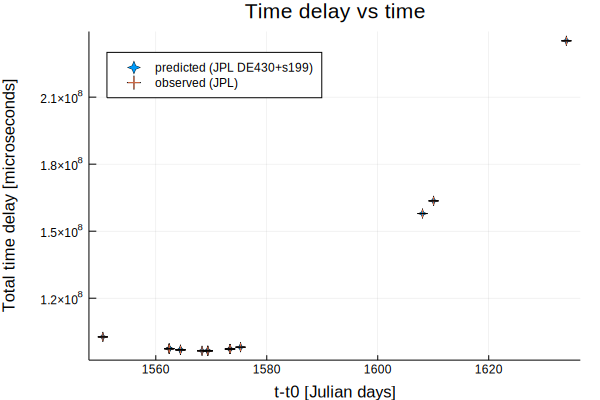

In [49]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    tdelay_JPL_v1[tv_del_ind],
    label="predicted (JPL DE430+s199)",
    marker=:star4
)
#scatter!(
#    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
#    tdelay_v1[tv_del_ind](),
#    label="predicted (TaylorIntegration.jl)",
#    marker=:xcross
#)
scatter!(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    Float64.(jpl_radar[del_ind,3]),
    label="observed (JPL)",
    legend=:topleft,
    marker=:cross,
    yerror=Float64.(jpl_radar[del_ind,4])
)
title!("Time delay vs time")
xlabel!("t-t0 [Julian days]")
ylabel!("Total time delay [microseconds]")

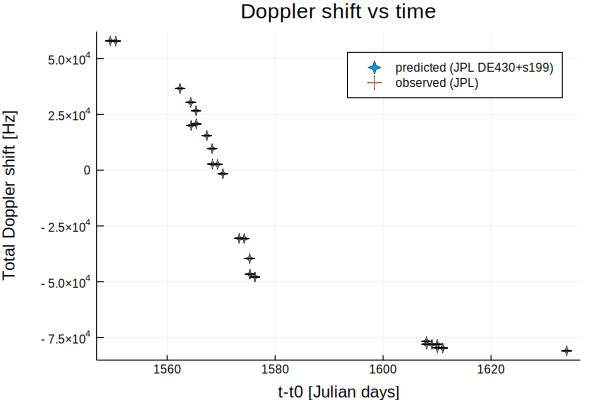

In [50]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    dshift_JPL_v1[tv_dop_ind],
    label="predicted (JPL DE430+s199)",
    marker=:star4
)
#scatter!(
#    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
#    dshift_v1[tv_dop_ind](),
#    label="predicted (TaylorIntegration.jl)",
#    marker=:xcross
#)
scatter!(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    Float64.(jpl_radar[dop_ind,3]),
    label="observed (JPL)",
    legend=:topright,
    marker=:cross,
    yerror=Float64.(jpl_radar[dop_ind,4])
)
title!("Doppler shift vs time")
xlabel!("t-t0 [Julian days]")
ylabel!("Total Doppler shift [Hz]")
#xlims!(1600,1640)

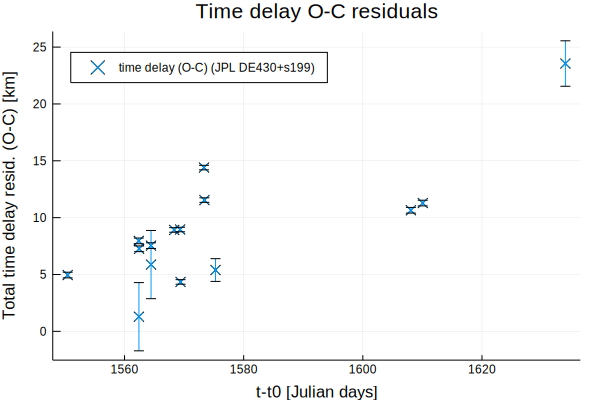

In [51]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    299792.458*1e-6residual_JPL_td,
    yerror=Float64.(jpl_radar[del_ind,4]),
    marker=:xcross,
    label = "time delay (O-C) (JPL DE430+s199)",
    legend = :topleft
)
#scatter!(
#    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
#    residual_td(),
#    yerror=Float64.(jpl_radar[del_ind,4]),
#    marker=:cross,
#    label = "time delay (O-C) (TaylorIntegration.jl)"
#)
title!("Time delay O-C residuals")
xlabel!("t-t0 [Julian days]")
ylabel!("Total time delay resid. (O-C) [km]")

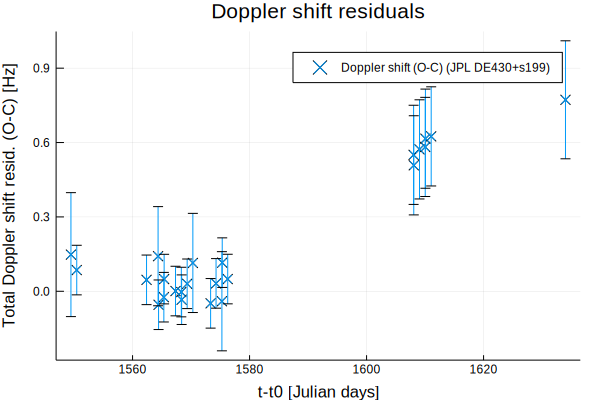

In [52]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    residual_JPL_ds,
    yerror=Float64.(jpl_radar[dop_ind,4]),
    marker=:xcross,
    label = "Doppler shift (O-C) (JPL DE430+s199)"
)
#scatter!(
#    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
#    residual_ds(),
#    yerror=Float64.(jpl_radar[dop_ind,4]),
#    marker=:cross,
#    label = "Doppler shift (O-C) (TaylorIntegration.jl)",
#    legend=:bottomright
#)
title!("Doppler shift residuals")
xlabel!("t-t0 [Julian days]")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")

scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    (299792458*1e-9/2)*residual_JPL_td,
    yerror=(299792458*1e-9/2)*Float64.(jpl_radar[del_ind,4]),
    marker=:xcross,
    label = "time delay (O-C) (JPL DE430+s199)"
)
title!("Time delay O-C residuals")
xlabel!("t-t0 [Julian days]")
ylabel!("Total time delay resid. (O-C) [km]")

scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    residual_JPL_ds,
    yerror=Float64.(jpl_radar[dop_ind,4]),
    marker=:xcross,
    label = "Doppler shift (O-C) (JPL DE430+s199)"
)

In [ ]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    rel_res_td(),
    yerror=Float64.(jpl_radar[del_ind,4])./Float64.(jpl_radar[del_ind,3]),
    label="Relative time delay O-C resid. (TaylorIntegration)",
    marker=:cross,
    legend=:topright
)
scatter!(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    rel_res_JPL_td,
    yerror=Float64.(jpl_radar[del_ind,4])./Float64.(jpl_radar[del_ind,3]),
    label="Relative time delay residual (DE430+s199)",
    marker=:xcross,
    legend=:topright
)
title!("Time delay relative O-C resid.")
xlabel!("t-t0 [Julian days]")

In [ ]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    rel_res_ds(),
    yerror=Float64.(jpl_radar[dop_ind,4])./Float64.(jpl_radar[dop_ind,3]),
    label="Relative Doppler shift O-C resid. (TI)",
    legend=:bottomright,
    marker=:cross
)
scatter!(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    rel_res_JPL_ds,
    yerror=Float64.(jpl_radar[dop_ind,4])./Float64.(jpl_radar[dop_ind,3]),
    label="Relative Doppler shift O-C resid. (JPL)",
    legend=:bottomright,
    marker=:xcross
)
title!("Doppler shift relative residuals")
xlabel!("t-t0 [Julian days]")

plot(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    rel_res_JPL_td,
    yerror=Float64.(jpl_radar[del_ind,4])./Float64.(jpl_radar[del_ind,3]),
    label="Relative time delay residual (DE430+s199)",
    marker=:xcross,
    legend=:topright
)

scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    rel_res_JPL_ds,
    yerror=Float64.(jpl_radar[dop_ind,4])./Float64.(jpl_radar[dop_ind,3]),
    label="Relative Doppler shift O-C resid. (JPL)",
    legend=:bottomright,
    marker=:xcross
)

In [ ]:
tv_jpl_integ

In [ ]:
tvS1[end]()

In [ ]:
tvS1[end-1]()-t0

In [ ]:
tv_jpl_integ .> tvS1[end]()

# Yarkovsky $A_2$ coefficient estimation

In [ ]:
tdelay_v1[1] # τ(A2) = p(A2)

In [ ]:
tdelay_v1[1]-constant_term(tdelay_v1[1]) # δτ(A2) = τ(A2) - τ(A2=0) = p(A2) - τ(A2=0) = p[1]*A2+p[2]*A2^2+... ( p[0]=τ(A2=0) )

In [ ]:
inverse( tdelay_v1[1]-constant_term(tdelay_v1[1]) ) # A2(δτ) = q(δτ) = q[1]*δτ+q[2]*δτ^2+... (q[0]=0)

In [ ]:
td_us = tdelay_v1[tv_del_ind]
ds_Hz = dshift_v1[tv_dop_ind];

In [ ]:
A2_δτ_v = (  inverse.( td_us-td_us() )  ) # vector of A2(δr) polynomials at each delay observation;
A2_δf_v = (  inverse.( ds_Hz-ds_Hz() )  ) # vector of A2(δvr) polynomials at each Doppler observation;

In [ ]:
A2_del_v = map((x,y)->x(y), A2_δτ_v, residual_td()); # A2(δτ) polynomials evaluated at the O-C time delay residuals;
A2_dop_v = map((x,y)->x(y), A2_δf_v, residual_ds()); # A2(δf_Doppler) polynomials evaluated at the O-C Doppler shift residuals;

In [ ]:
A2_del_v

In [ ]:
A2_dop_v

In [ ]:
mean(A2_del_v), std(A2_del_v)

In [ ]:
mean(A2_dop_v), std(A2_dop_v)

In [ ]:
scatter(tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0, A2_del_v, leg=false, marker=:cross)
xlabel!("t-t0 [Julian days]")
ylabel!("A2(dt) x 10^14 [au/d^2]")
ylims!(1.1minimum(A2_del_v),0)

In [ ]:
scatter(tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0, A2_dop_v, leg=false, marker=:cross)
xlabel!("t-t0 [Julian days]")
ylabel!("A2(df) x 10^14 [au/d^2]")
ylims!(1.1minimum(A2_dop_v),0)

# Intervals

In [ ]:
using IntervalArithmetic

In [ ]:
residual_td_interval = interval.(
    (jpl_radar[del_ind,3]-jpl_radar[del_ind,4])-tdelay_v1[tv_del_ind](), 
    (jpl_radar[del_ind,3]+jpl_radar[del_ind,4])-tdelay_v1[tv_del_ind]()
)

In [ ]:
residual_ds_interval = interval.(
    (jpl_radar[dop_ind,3]-jpl_radar[dop_ind,4])-dshift_v1[tv_dop_ind](),
    (jpl_radar[dop_ind,3]+jpl_radar[dop_ind,4])-dshift_v1[tv_dop_ind]()
)

In [ ]:
A2_del_v_interval = map((x,y)->x(y), A2_δτ_v, residual_td_interval)

In [ ]:
A2_dop_v_interval = map((x,y)->x(y), A2_δf_v, residual_ds_interval)

In [ ]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    A2_del_v,
    yerror=radius.(A2_del_v_interval),
    leg=false,
    marker=:cross
)
ylims!(minimum(A2_del_v)-1,0)
ylabel!("A2(dt) x 10^14 [au/d^2]")
xlabel!("t-t0 [Julian days]")

In [ ]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    A2_dop_v,
    yerror=radius.(A2_dop_v_interval),
    leg=false,
    marker=:cross
)
ylabel!("A2(df) x 10^14 [au/d^2]")
xlabel!("t-t0 [Julian days]")

In [ ]:
scatter(
    tv_jpl_utc_julian_unrepeated[tv_del_ind .+ 1].-t0,
    A2_del_v,
    yerror=radius.(A2_del_v_interval),
    leg=false,
    marker=:cross
)
scatter!(
    tv_jpl_utc_julian_unrepeated[tv_dop_ind .+ 1].-t0,
    A2_dop_v,
    yerror=radius.(A2_dop_v_interval),
    leg=false,
    marker=:cross
)